In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import time
from datetime import datetime, timedelta
import lightgbm
import plotly.express as px

In [5]:
!pip list | grep 'pandas\|numpy\|tqdm\|skleanr\|catboost\|scikit-learn\|pickle\|calendra'

catboost                      1.1.1
cloudpickle                   2.2.1
numpy                         1.23.5
pandas                        1.5.2
pickleshare                   0.7.5
scikit-learn                  1.2.0
tqdm                          4.64.1


In [6]:
data = pd.read_csv('solo_shop.csv').sort_values(by='dt')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'solo_shop.csv'

In [ ]:
(data['gtin'].value_counts() > 100).sum()

In [ ]:
data['gtin'].nunique()

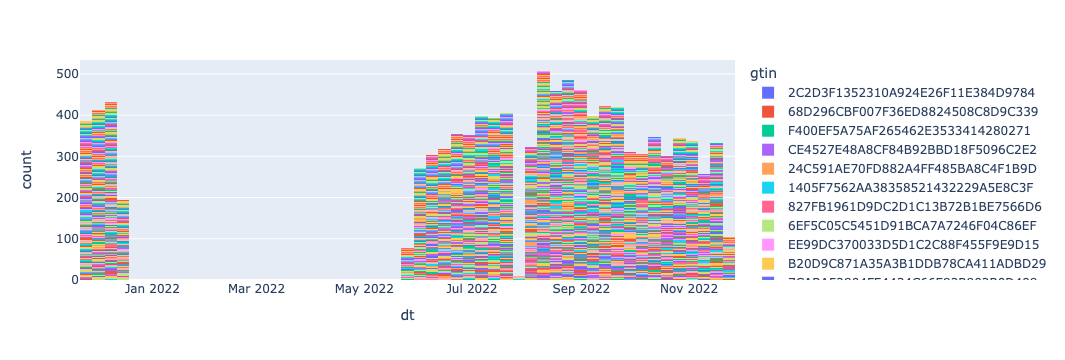

In [20]:
px.histogram(data[data['id_sp_'] == '0E155CD38869DC277F68959405FD6CFA'], x='dt', color='gtin')

In [16]:
data['gtin'].value_counts()

0F40E9DE2E7DBC0DA161448D98D47C69    12015
1AF3D5B9E053CBDF908FB967FE3543AA     9172
1A98A1EB588F10773B00201735CB4991     8646
8B76211744D54CE6EB125BE8611B29A7     8059
016B9003937AE83CA305958CEBA36FEF     7590
                                    ...  
04C7617A37A8C06C33DD7BD45C9294F9        1
0172A781E5D14DAA024F5A447C238194        1
D7C83888C6CBDE5801A1B00A2EB0528E        1
303111FA97C8E84961D5D197019B36B5        1
49C0F859195D189F80955B6EE8C17AD0        1
Name: gtin, Length: 9269, dtype: int64

In [13]:
data.groupby(['id_sp_', 'gtin'])['dt'].nunique()

id_sp_                            gtin                            
02DCBDBCDDEED5C6F2745F98B66441EA  0044BE7AA4BE1481389D6F23EE8AEAF2    3
                                  00607B2F926E755BB8E4761E1B79BD9C    1
                                  008F0DE7FC1ED920B16F346ECE148020    3
                                  0129331E8C601F46FB6959F801E7D62B    1
                                  023185562958EDC5AE67B5D77FC32904    2
                                                                     ..
FE0935DFD9AF498A8E3A2DEEC9A26072  FD814263CA9F6F18DFD82A51677CCACD    2
                                  FD93580C572F1D2EA34C162870661FCB    1
                                  FDEEEE8D381CF7B7CB17CF15B6096F89    2
                                  FE3B4CD0A9A5769560A8E32E562A5407    1
                                  FF5622705899B53E80C71FFAF1B4D714    1
Name: dt, Length: 353850, dtype: int64

In [12]:
data['type_operation'].value_counts()

Продажа конечному потребителю в точке продаж    2135724
Дистанционная продажа конечному потребителю      109805
Прочий тип вывода из оборота                      16588
Списание / Вывод из оборота без получателя          361
Конечная продажа организации                        320
Продажи за пределы РФ                                97
Name: type_operation, dtype: int64

In [8]:
data['inn'].unique()

array(['6B8E111AB5B5C556C0AEA292ACA4D88B'], dtype=object)

In [9]:
data['inn'].isna().sum()

0

In [11]:
data['id_sp_'].isna().mean()

0.30108776589280545

In [10]:
data['id_sp_'].value_counts()

3D1D20C0C33E6478BD4B6AA005858479    30478
32246224A0B2950C19FAC96BC145F73F    27801
1B398061561B35FE8F4865C8AB024075    27222
69376E48B489D54BBFA3D6C9BDB1AD63    24308
F67FF886857EE4DD67D3FB2CF7E3B52C    21252
                                    ...  
A029A19C4C4BA36183F90C633D1439E3        1
81362B7A4BBFEEAE3E3795186EF95DBD        1
F50B2FA5625D7705F8616BE82D972E27        1
9233D93E2D6B6B06330D9A3AA80773EE        1
1CF9CB0CA063E6C6BE16E66F0D9AABFF        1
Name: id_sp_, Length: 286, dtype: int64

In [7]:
data.groupby(['inn'])[['gtin', 'prid']].nunique()

,gtin,prid
inn,,
6B8E111AB5B5C556C0AEA292ACA4D88B,9269,38


In [6]:
data[(data['gtin'] == '2C2D3F1352310A924E26F11E384D9784') & (data['inn'] == '6B8E111AB5B5C556C0AEA292ACA4D88B')]

,dt,gtin,prid,inn,id_sp_,type_operation,price,cnt
7895,2021-11-22,2C2D3F1352310A924E26F11E384D9784,A43BE3249A22A8CCB7AE1F6D1B1477D0,6B8E111AB5B5C556C0AEA292ACA4D88B,0E155CD38869DC277F68959405FD6CFA,Продажа конечному потребителю в точке продаж,78557,1
4673,2021-11-22,2C2D3F1352310A924E26F11E384D9784,A43BE3249A22A8CCB7AE1F6D1B1477D0,6B8E111AB5B5C556C0AEA292ACA4D88B,A9F916B567DEF0200B232E5838D1FF38,Продажа конечному потребителю в точке продаж,78557,1
7919,2021-11-22,2C2D3F1352310A924E26F11E384D9784,A43BE3249A22A8CCB7AE1F6D1B1477D0,6B8E111AB5B5C556C0AEA292ACA4D88B,CED30EC32B77DA7C78E69E75A47CAD0E,Продажа конечному потребителю в точке продаж,78557,1
20345,2021-11-22,2C2D3F1352310A924E26F11E384D9784,A43BE3249A22A8CCB7AE1F6D1B1477D0,6B8E111AB5B5C556C0AEA292ACA4D88B,NaN,Продажа конечному потребителю в точке продаж,78557,3
99775,2021-11-23,2C2D3F1352310A924E26F11E384D9784,A43BE3249A22A8CCB7AE1F6D1B1477D0,6B8E111AB5B5C556C0AEA292ACA4D88B,7E9B0DA12006D7A315D35DBAA935F5B9,Продажа конечному потребителю в точке продаж,78557,1
...,...,...,...,...,...,...,...,...
2234479,2022-11-20,2C2D3F1352310A924E26F11E384D9784,A43BE3249A22A8CCB7AE1F6D1B1477D0,6B8E111AB5B5C556C0AEA292ACA4D88B,8DC771A98A101E9389504F906C5E422E,Продажа конечному потребителю в точке продаж,117085,1
2231676,2022-11-20,2C2D3F1352310A924E26F11E384D9784,A43BE3249A22A8CCB7AE1F6D1B1477D0,6B8E111AB5B5C556C0AEA292ACA4D88B,5AD1A58E9CFDE488E3315293CCF406DB,Продажа конечному потребителю в точке продаж,117085,1
2262154,2022-11-21,2C2D3F1352310A924E26F11E384D9784,A43BE3249A22A8CCB7AE1F6D1B1477D0,6B8E111AB5B5C556C0AEA292ACA4D88B,A9F916B567DEF0200B232E5838D1FF38,Продажа конечному потребителю в точке продаж,135100,1
2218827,2022-11-21,2C2D3F1352310A924E26F11E384D9784,A43BE3249A22A8CCB7AE1F6D1B1477D0,6B8E111AB5B5C556C0AEA292ACA4D88B,3998CD031AE705195AAF0A63B52C95EF,Продажа конечному потребителю в точке продаж,135100,1


In [3]:
data.shape

(2262895, 8)

In [5]:
data.groupby(['inn', 'gtin'])['price'].std()

inn                               gtin                            
6B8E111AB5B5C556C0AEA292ACA4D88B  000353B28DA976A5CB2A71139AE83E7B    39319.338018
                                  000ED2D0FEEFCB166F2E60DF05368A14    41705.648682
                                  001DD284810DEFDD787F4DDFF662EA1F    25957.408877
                                  001E37C5AEF7D80112B325441B908ACD    73832.921688
                                  002C3D5DDD194A3837BEE8B3857F2C2F    83970.021620
                                                                          ...     
                                  FFD98FE9A4F6D9C3FC2C47B73778F9BA    19194.326141
                                  FFE2D1758B99E61B60C6678E5CDD3547    29298.641196
                                  FFE982FAC2AF7BAC19774BB12644BB61    60687.058932
                                  FFF80EAE28388398AB69FB3B9D7356AD     9854.238370
                                  FFFCD8A980B739872B7B5F70B8F55E81    90512.567101
Name: price, Length:

## Features Engineering

In [9]:
data = pd.read_csv('data/solo_shop.csv').sort_values(by='dt').reset_index(drop=True)
data = data.rename(columns={'dt': 'date', 'gtin': 'item', 'id_sp_': 'store', 'cnt': 'sales'})
data = data.drop(columns='inn', axis=1)
data = data.dropna(subset='store')
data.shape

(1581565, 7)

In [10]:
data.head(5).drop(columns=['prid', 'type_operation', 'sales'])

,date,item,store,price
0,2021-11-22,2C2D3F1352310A924E26F11E384D9784,0E155CD38869DC277F68959405FD6CFA,78557
1,2021-11-22,B7968C32BFF3AA26447C873654617FC6,68AFC705887159893F33E537F5EB0D88,85142
3,2021-11-22,7CB922A7FCDF4C3B926909E43CDC1E4E,8F2F4EFDAF546C2D6897FAF55F0D107B,24271
4,2021-11-22,832C2D353A101B78E2916FB6A3A9DA6C,1A7D8F22AD08CD78628D80CF4B76040C,37128
5,2021-11-22,3C402BE1683D26FBA378564351218D2B,1A7D8F22AD08CD78628D80CF4B76040C,49985


In [11]:
cnt = data.groupby(['store', 'item'])['sales'].count()
data = data[data.apply(lambda x: cnt[(x['store'], x['item'])] > 100, axis=1)]
data.shape

(12825, 7)

In [535]:
for col in ['item', 'store', 'prid']:
    mp = {a: b for a, b in zip(np.unique(data[col]), np.arange(data[col].nunique()))}
    data.loc[:, col] = data[col].apply(lambda x: mp[x])
    data.loc[:, col] = data[col].astype('int')

data.head()

,date,item,prid,store,type_operation,price,sales,store_item
105,2021-11-01,8,0,25,Продажа конечному потребителю в точке продаж,141714,1,DE3FBFFC682914FBD0A9BC5EC6BAE198_50CD8E20B9B0A...
317,2021-11-01,2,0,20,Продажа конечному потребителю в точке продаж,8557,2,91F389DD8A8DC65C2281DA8BC9AAC534_11EC04D3BC08B...
441,2021-11-01,0,0,11,Продажа конечному потребителю в точке продаж,8557,1,48FD0389396A6664DEBCDA08CCA2F407_016B9003937AE...
509,2021-11-01,0,0,6,Продажа конечному потребителю в точке продаж,8557,1,32246224A0B2950C19FAC96BC145F73F_016B9003937AE...
653,2021-11-01,9,3,23,Продажа конечному потребителю в точке продаж,49985,1,CED30EC32B77DA7C78E69E75A47CAD0E_56A4CEAF7E37D...


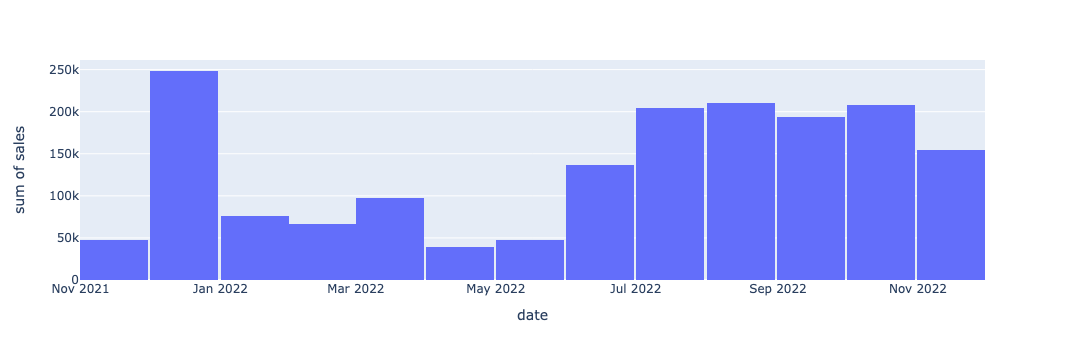

In [521]:
px.histogram(data.groupby('date')['sales'].sum().reset_index(), x='date', y='sales')

In [282]:
data.groupby(['store', 'item'])['date'].nunique().mean()

19.407774275851718

In [283]:
data['date'] = data['date'].apply(lambda x: x[:-2] + '01')

In [284]:
df = data.groupby(['store', 'item', 'date']).agg(sales = ('sales', 'sum'),
                                                   price = ('price', 'mean')).reset_index()
df.head()

,store,item,date,sales,price
0,0,195,2022-06-01,2,31385.0
1,0,195,2022-07-01,3,27828.0
2,0,195,2022-08-01,2,31385.0
3,0,195,2022-11-01,9,29995.0
4,0,280,2022-06-01,3,102000.0


In [285]:
all_dates = df['date'].unique()

In [286]:
add = []
x = df.groupby(['store', 'item'])['date'].unique()
for store_item, now_dates in tqdm(list(x.items())):
    for d in all_dates:
        if d not in now_dates:
            add.append({'store': store_item[0],
                        'item': store_item[1],
                        'date': d,
                        'sales': 0})
            
df = pd.concat([df, pd.DataFrame(add)])
df.shape

100%|█████████████████████████████████| 33315/33315 [00:00<00:00, 35097.25it/s]


(433095, 5)

In [287]:
df['train_or_test'] = np.where(df['date'] < '2022-10-01', 'train', 'val')

In [288]:
def fill_price(prices):
    L = np.ones(len(prices)) * -1
    R = np.ones(len(prices)) * -1
    for i in range(len(prices)):
        if prices[i] == prices[i]: #not is nan
            L[i] = prices[i]
        elif i > 0:
            L[i] = L[i - 1]
    
    for i in range(len(prices) - 1, -1, -1):
        if prices[i] == prices[i]: #not is nan
            R[i] = prices[i]
        elif i != len(prices) - 1:
            R[i] = R[i + 1]
            
    for i in range(len(prices)):
        if prices[i] != prices[i]:
            if L[i] == -1:
                prices[i] = R[i]
            elif R[i] == -1:
                prices[i] = L[i]
            else:
                prices[i] = (L[i] + R[i]) / 2
    return prices

groups = df.sort_values(by='date').groupby(['store', 'item'])['price']

res = []
for group in tqdm(groups):
    res += fill_price(group[1].values).tolist()

100%|█████████████████████████████████| 33315/33315 [00:00<00:00, 46435.28it/s]


In [289]:
df.sort_values(by=['store','item', 'date'], axis=0, inplace=True)

In [290]:
df['price'] = res
df.head()

,store,item,date,sales,price,train_or_test
2,0,195,2021-11-01,0,31385.0,train
3,0,195,2021-12-01,0,31385.0,train
7,0,195,2022-01-01,0,31385.0,train
4,0,195,2022-02-01,0,31385.0,train
5,0,195,2022-03-01,0,31385.0,train


In [291]:
for i, el in enumerate(groups):
    if i == 17:
        print(el)
        print(fill_price(el[1].values))
        break

((1, 46), 122        NaN
103    52200.0
124        NaN
123        NaN
104    58500.0
105    85307.0
106    78000.0
118        NaN
107    54271.0
119        NaN
121        NaN
108    49985.0
120        NaN
Name: price, dtype: float64)
[52200.  52200.  55350.  55350.  58500.  85307.  78000.  66135.5 54271.
 52128.  52128.  49985.  49985. ]


In [292]:
df[(df['store'] == 1) & (df['item'] == 46)]

,store,item,date,sales,price,train_or_test
122,1,46,2021-11-01,0,52200.0,train
103,1,46,2021-12-01,1,52200.0,train
124,1,46,2022-01-01,0,55350.0,train
123,1,46,2022-02-01,0,55350.0,train
104,1,46,2022-03-01,1,58500.0,train
105,1,46,2022-04-01,2,85307.0,train
106,1,46,2022-05-01,2,78000.0,train
118,1,46,2022-06-01,0,66135.5,train
107,1,46,2022-07-01,2,54271.0,train
119,1,46,2022-08-01,0,52128.0,train


### Date Features

In [293]:
df['date'] = pd.to_datetime(df['date'])

In [294]:
# df['dayofmonth'] = df.date.dt.day
# df['dayofyear'] = df.date.dt.dayofyear
# df['dayofweek'] = df.date.dt.dayofweek
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
# df['weekofyear'] = df.date.dt.weekofyear
# df['is_month_start'] = (df.date.dt.is_month_start).astype(int)
# df['is_month_end'] = (df.date.dt.is_month_end).astype(int)
df.head()

,store,item,date,sales,price,train_or_test,month,year
2,0,195,2021-11-01,0,31385.0,train,11,2021
3,0,195,2021-12-01,0,31385.0,train,12,2021
7,0,195,2022-01-01,0,31385.0,train,1,2022
4,0,195,2022-02-01,0,31385.0,train,2,2022
5,0,195,2022-03-01,0,31385.0,train,3,2022


In [295]:
df.groupby(['store'])['item'].nunique().sum()

33315

In [296]:
df.sort_values(by=['store','item','date'], axis=0, inplace=True)

### Add background information

In [297]:
df.shape

(433095, 8)

In [298]:
def get_product_info(path):
    products_info = pd.read_csv(path)
    
    products_info['item'] = products_info['gtin'].apply(lambda x: preprocesser.hash_to_numbers['item'][x] if x in 
                                                                preprocesser.hash_to_numbers['item'] else np.nan)
    products_info = products_info.dropna(subset='item')
    products_info = products_info.drop(columns='gtin')
    products_info = products_info.drop_duplicates(subset='item', keep='last')
    
    products_info['volume'] = products_info['volume'].replace('НЕ КЛАССИФИЦИРОВАНО', np.nan)
    products_info['volume'] = products_info['volume'].apply(lambda x: float(x.replace(',', '.').replace(' г', ''))
                                                                        if x == x else np.nan)
    return products_info

def get_store_info(path):
    store_info = pd.read_csv(path).drop(columns='inn')
    store_info['store'] = store_info['id_sp_'].apply(lambda x: preprocesser.hash_to_numbers['store'][x] if x in 
                                                          preprocesser.hash_to_numbers['store'] else np.nan)
    store_info = store_info.dropna(subset='store')
    store_info = store_info.drop(columns='id_sp_')
    store_info = store_info.drop_duplicates(subset='store', keep='last')
    return store_info

In [299]:
products_info = get_product_info('data/Справочник продукции.csv')
products_info.head()

,inn,product_name,product_short_name,tnved,tnved10,brand,country,volume,item
85,EF97FB7B958BBC9476716CD392CF8E54,57005B6A51DBB22DCF72A00AEBC3B08A,2868B842B46F754C088D89E130F89585,6D2580183CEF6C8AF1CC72E1C6E6FBC4,58A4B52373651DA4292AD5725D388F8A,01FFE242F3D8D805AC55CF37D3E2BC17,NaN,10.0,7781.0
86,EF97FB7B958BBC9476716CD392CF8E54,219ABE017CE60EADF61738F9E2A48F1A,2868B842B46F754C088D89E130F89585,6D2580183CEF6C8AF1CC72E1C6E6FBC4,58A4B52373651DA4292AD5725D388F8A,01FFE242F3D8D805AC55CF37D3E2BC17,NaN,45.0,1262.0
87,EF97FB7B958BBC9476716CD392CF8E54,3623A49504222A1DEF79A23526882035,2868B842B46F754C088D89E130F89585,6D2580183CEF6C8AF1CC72E1C6E6FBC4,58A4B52373651DA4292AD5725D388F8A,01FFE242F3D8D805AC55CF37D3E2BC17,NaN,25.0,3419.0
95,6B8E111AB5B5C556C0AEA292ACA4D88B,1876F992B481F370F0FF71388F4D3F28,9199AB529CF62D4BDB7E8B1D7459001D,6D2580183CEF6C8AF1CC72E1C6E6FBC4,FAEA36DABA0E46CD081A7FA49DAD8FE0,01FFE242F3D8D805AC55CF37D3E2BC17,NaN,50.0,3221.0
118,0148C071E610B08232629EAF55662A99,337FBA4127108459B7E338192F84F0E0,C6AD4B84092CCBB3E3729F73B00C55A1,6D2580183CEF6C8AF1CC72E1C6E6FBC4,FAEA36DABA0E46CD081A7FA49DAD8FE0,01FFE242F3D8D805AC55CF37D3E2BC17,NaN,50.0,6591.0


In [300]:
store_info = get_store_info('data/Справочник торговых точек.csv')
store_info.head()

,region_code,city_with_type,city_fias_id,postal_code,store
38,64,г Саратов,bf465fda-7834-47d5-986b-ccdb584a85a6,410005.0,181.0
48,77,NaN,NaN,111622.0,10.0
57,64,г Саратов,bf465fda-7834-47d5-986b-ccdb584a85a6,410012.0,239.0
374,47,г Кудрово,98cd19c4-e172-4fa3-a81d-7caedeec669b,188692.0,167.0
729,55,г Омск,140e31da-27bf-4519-9ea0-6185d681d44e,644024.0,78.0


In [301]:
df = df.merge(store_info, on='store', how='left')
df = df.merge(products_info, on='item', how='left')
df.head(5)

,store,item,date,sales,price,train_or_test,month,year,region_code,city_with_type,city_fias_id,postal_code,inn,product_name,product_short_name,tnved,tnved10,brand,country,volume
0,0,195,2021-11-01,0,31385.0,train,11,2021,77,NaN,NaN,117588.0,5A96B9812186BDEEBE3642E0F0148775,7F2ED3710B9F591DB3FC05A6892F1C92,B8AF2335E04E7BAD5168D9B39FABAC21,6D2580183CEF6C8AF1CC72E1C6E6FBC4,FAEA36DABA0E46CD081A7FA49DAD8FE0,60491AB8FECDD08CA4C04B3E6D659407,NaN,50.0
1,0,195,2021-12-01,0,31385.0,train,12,2021,77,NaN,NaN,117588.0,5A96B9812186BDEEBE3642E0F0148775,7F2ED3710B9F591DB3FC05A6892F1C92,B8AF2335E04E7BAD5168D9B39FABAC21,6D2580183CEF6C8AF1CC72E1C6E6FBC4,FAEA36DABA0E46CD081A7FA49DAD8FE0,60491AB8FECDD08CA4C04B3E6D659407,NaN,50.0
2,0,195,2022-01-01,0,31385.0,train,1,2022,77,NaN,NaN,117588.0,5A96B9812186BDEEBE3642E0F0148775,7F2ED3710B9F591DB3FC05A6892F1C92,B8AF2335E04E7BAD5168D9B39FABAC21,6D2580183CEF6C8AF1CC72E1C6E6FBC4,FAEA36DABA0E46CD081A7FA49DAD8FE0,60491AB8FECDD08CA4C04B3E6D659407,NaN,50.0
3,0,195,2022-02-01,0,31385.0,train,2,2022,77,NaN,NaN,117588.0,5A96B9812186BDEEBE3642E0F0148775,7F2ED3710B9F591DB3FC05A6892F1C92,B8AF2335E04E7BAD5168D9B39FABAC21,6D2580183CEF6C8AF1CC72E1C6E6FBC4,FAEA36DABA0E46CD081A7FA49DAD8FE0,60491AB8FECDD08CA4C04B3E6D659407,NaN,50.0
4,0,195,2022-03-01,0,31385.0,train,3,2022,77,NaN,NaN,117588.0,5A96B9812186BDEEBE3642E0F0148775,7F2ED3710B9F591DB3FC05A6892F1C92,B8AF2335E04E7BAD5168D9B39FABAC21,6D2580183CEF6C8AF1CC72E1C6E6FBC4,FAEA36DABA0E46CD081A7FA49DAD8FE0,60491AB8FECDD08CA4C04B3E6D659407,NaN,50.0


In [302]:
df.shape

(433095, 20)

### Monthwise aggregated sales values

In [303]:
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    '''
    Creates various sales agg features with given agg functions  
    '''
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

### Features constructed from previous sales values

In [304]:
# Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1, size=(len(df),)) * 0
    return df

# Creating sales rolling mean features
def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1, size=(len(df),)) * 0
    return df

# Creating sales rolling median features
def create_sales_rmed_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1, size=(len(df),)) * 0
    return df

# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

### OHE of categorical features

In [305]:
def one_hot_encoder(df, ohe_cols=['store','item','dayofmonth','dayofweek','month','weekofyear']):
    '''
    One-Hot Encoder function
    '''
    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))
    df = pd.get_dummies(df, columns=ohe_cols)
    print('New df shape:{}'.format(df.shape))
    return df

### Log Sales

In [306]:
# df['sales'] = np.log1p(df.sales.values)
# df.sample(2)

### Building features

In [307]:
df.shape

(433095, 20)

In [308]:
# Converting sales of validation period to nan so as to resemble test period
train = df.loc[df.train_or_test.isin(['train','val']), :]
y_val = train.loc[train.train_or_test=='val', 'sales'].values.reshape((-1))
y_train = train.loc[train.train_or_test=='train', 'sales'].values.reshape((-1))
train.loc[train.train_or_test=='val', 'sales'] = np.nan

# # Creating sales lag, rolling mean, rolling median, ohe features of the above train set
train = create_sales_lag_feats(train, gpby_cols=['store','item'], target_col='sales', 
                               lags=[1, 3, 6, 12])

train = create_sales_rmean_feats(train, gpby_cols=['store','item'], 
                                 target_col='sales', windows=[1, 2, 3, 6, 12], 
                                 min_periods=1, win_type='triang')

train = create_sales_rmed_feats(train, gpby_cols=['store','item'], 
                                 target_col='sales', windows=[2, 3, 6, 12], 
                                 min_periods=2, win_type=None)

train = create_sales_ewm_feats(train, gpby_cols=['store','item'], 
                               target_col='sales', 
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                               shift=[1, 3, 6, 12])

train = create_sales_rmean_feats(train, gpby_cols=['store','item'], 
                                 target_col='price', windows=[2, 3, 6, 12], 
                                 min_periods=2,)


# # Creating sales monthwise aggregated values
# agg_df = create_sales_agg_monthwise_features(df.loc[df.train_or_test=='train', :], 
#                                              gpby_cols=['store','item','month'], 
#                                              target_col='sales', 
#                                              agg_funcs={'mean':np.mean, 
#                                              'median':np.median, 'max':np.max, 
#                                              'min':np.min, 'std':np.std})

# # Joining agg_df with train
# train = train.merge(agg_df, on=['store','item','month'], how='left')

# One-Hot Encoding 
# train = one_hot_encoder(train, ohe_cols=['store', 'item', 'month']) 
#,'dayofmonth','weekofyear'

# Final train and val datasets
val = train.loc[train.train_or_test=='val', :]
train = train.loc[train.train_or_test=='train', :]
print('Train shape:{}, Val shape:{}'.format(train.shape, val.shape))

Train shape:(366465, 60), Val shape:(66630, 60)


In [309]:
train.sample(3)

,store,item,date,sales,price,train_or_test,month,year,region_code,city_with_type,...,sales_lag_6_ewm_0.6,sales_lag_12_ewm_0.6,sales_lag_1_ewm_0.5,sales_lag_3_ewm_0.5,sales_lag_6_ewm_0.5,sales_lag_12_ewm_0.5,price_rmean_2,price_rmean_3,price_rmean_6,price_rmean_12
38199,20,1702,2022-04-01,0.0,77300.0,train,4,2022,23,г Сочи,...,0.740219,9.274828e-114,0.650864,0.609049,0.724402,4.825246e-86,69675.0,62050.0,55950.000000,79751.893939
333874,178,649,2022-07-01,4.0,34271.0,train,7,2022,47,г Гатчина,...,0.743404,2.000007e+00,0.022048,0.089152,0.713090,2.000122e+00,35699.5,35699.5,35937.583333,41078.090909
330949,176,1399,2022-07-01,1.0,66585.0,train,7,2022,47,NaN,...,1.666201,0.000000e+00,0.049094,0.198516,1.710497,0.000000e+00,54713.5,54713.5,52734.916667,50229.154545


In [310]:
drop_cols = ['date', 'sales', 'train_or_test', 'year', 'product_name', 'month']
X_train = train.drop(columns=drop_cols)
X_val = val.drop(columns=drop_cols)
X_train.shape, X_val.shape

((366465, 54), (66630, 54))

## Train catboost

In [311]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

def smape(preds, target):
    '''
    Function to calculate SMAPE
    '''
    n = len(preds)
    masked_arr = ~((preds==0)&(target==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

In [312]:
cat_cols = ['store', 'item'] + \
           ['inn', 'product_short_name', 'tnved', 'tnved10', 'brand', 
            'country', 'region_code', 'city_with_type', 'city_fias_id', 'postal_code']

params_cat = {'n_estimators' : 1000,
          'learning_rate': .03,
          'depth' : 3,
          'use_best_model': True,
          'cat_features' : cat_cols,
          # 'text_features': text_cols,
          # 'train_dir' : '/home/jovyan/work/catboost',
          # 'border_count' : 64,
          'l2_leaf_reg' : 1,
          # 'bagging_temperature' : 2,
          # 'rsm' : .1,
          # 'loss_function': 'MultiClass',
          # 'auto_class_weights' : 'Balanced', #try not balanced
          'random_state': 42,
          'eval_metric' : 'MAE'
         }

cat_model = CatBoostRegressor(**params_cat)

In [313]:
X_train[cat_cols] = X_train[cat_cols].fillna('unknown').astype('str')
X_val[cat_cols] = X_val[cat_cols].fillna('unknown').astype('str')

In [314]:
cat_model.fit(X_train, y_train, verbose=100, eval_set=(X_val, y_val), early_stopping_rounds=200)

0:	learn: 1.9186353	test: 1.7634101	best: 1.7634101 (0)	total: 140ms	remaining: 2m 19s
100:	learn: 1.5993968	test: 1.5548603	best: 1.5548603 (100)	total: 5.42s	remaining: 48.2s
200:	learn: 1.5154855	test: 1.5161940	best: 1.5157129 (194)	total: 10.3s	remaining: 41.1s
300:	learn: 1.4728283	test: 1.5127866	best: 1.5116569 (276)	total: 15.3s	remaining: 35.4s
400:	learn: 1.4486499	test: 1.5135461	best: 1.5114578 (324)	total: 20.2s	remaining: 30.1s
500:	learn: 1.4349350	test: 1.5125139	best: 1.5114578 (324)	total: 24.8s	remaining: 24.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 1.511457849
bestIteration = 324

Shrink model to first 325 iterations.


In [161]:
mp = df.groupby(['store', 'item'])['sales'].mean()
preds = X_val.apply(lambda el: mp[(el['store'], el['item'])] if (el['store'], el['item']) in mp else 0, axis=1)
mean_absolute_error(y_val, preds), smape(preds, y_val)

(18.2319587628866, 198.96907216494844)

In [210]:
pred = cat_model.predict(big_X_val)
mean_absolute_error(big_y_val, pred), smape(pred, big_y_val)

(9.464006776661614, 60.76750868739798)

In [315]:
pred = cat_model.predict(X_val)
mean_absolute_error(y_val, pred), smape(pred, y_val)

(1.5114588488939953, 103.53749890327455)

In [209]:
mp = df.groupby(['store', 'item'])['sales'].mean()
preds = X_val.apply(lambda el: mp[(el['store'], el['item'])] if (el['store'], el['item']) in mp else 0, axis=1)
mean_absolute_error(y_val, preds), smape(preds, y_val)

(2.0327480114062735, 133.26429536244936)

In [257]:
mp = df.groupby(['item'])['sales'].mean()
preds = X_val.apply(lambda el: mp[el['item']], axis=1)
mean_absolute_error(y_val, preds), smape(preds, y_val)

(0.5917755933909224, 173.1597072678853)

In [248]:
preds = cat_model.predict(X_val)
mean_absolute_error(y_val, preds), smape(preds, y_val)

(0.5399093360997136, 182.09267252672777)

In [465]:
import pickle

with open('model.pickle', 'wb') as f:
    pickle.dump(cat_model, f)

In [108]:
from catboost import Pool

fi = cat_model.get_feature_importance(Pool(X_val, y_val, cat_features=cat_cols),
                                      prettified=True)
fi.head(25)

,Feature Id,Importances
0,sales_rmean_3,19.737363
1,sales_lag_1,13.473987
2,sales_lag_3,8.142901
3,price,7.672493
4,sales_rmean_12,7.383541
5,item,6.773528
6,sales_rmed_3,6.770380
7,price_rmean_2,4.814952
8,store,4.241851
9,sales_rmean_2,2.816378


## Inference

In [450]:
from sklearn.base import BaseEstimator, TransformerMixin
import calendar
from datetime import date
import warnings
warnings.filterwarnings("ignore")

In [460]:
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return date(year, month, day)


class Preprocesser(BaseEstimator, TransformerMixin):
    def __init__(self, products_info_path, store_info_path):
        self.hash_to_numbers = {}
        self.numbers_to_hash = {}
        self.drop_cols = ['date', 'sales', 'year', 'product_name', 'month']
        self.products_info_path = products_info_path
        self.store_info_path = store_info_path
        self.cat_cols = ['store', 'item'] + \
                           ['inn', 'product_short_name', 'tnved', 'tnved10', 'brand', 
                            'country', 'region_code', 'city_with_type', 'city_fias_id', 'postal_code']
        self.mean_values = {}
        self.min_date = '2021-11-01'
        
    def fit(self, data):
        data = data.copy()
        data = data.rename(columns={'dt': 'date', 'gtin': 'item', 'id_sp_': 'store', 'cnt': 'sales'})
        data = data.drop(columns='inn', axis=1)
        data = data.dropna(subset='store')
        for col in ['item', 'store', 'prid']:
            self.hash_to_numbers[col] = {a: b for a, b in zip(np.unique(data[col]), np.arange(data[col].nunique()))}
            self.numbers_to_hash[col] = {b: a for a, b in zip(np.unique(data[col]), np.arange(data[col].nunique()))}
        
        return self
    
    def get_df(self, data):
        data = data.sort_values(by='dt').reset_index(drop=True)
        data = data.rename(columns={'dt': 'date', 'gtin': 'item', 'id_sp_': 'store', 'cnt': 'sales'})
        data = data.drop(columns='inn', axis=1)
        data = data.dropna(subset='store')
        
        for col in ['item', 'store', 'prid']:
            data.loc[:, col] = data[col].apply(lambda x: self.hash_to_numbers[col][x] if x in self.hash_to_numbers[col] else np.nan)
            data.loc[:, col] = data[col].astype('int')
        
        data['date'] = data['date'].apply(lambda x: x[:-2] + '01')
        df = data.groupby(['store', 'item', 'date']).agg(sales = ('sales', 'sum'),
                                                           price = ('price', 'mean')).reset_index()
        return df
        
    def add_zero_points(self, df, pred_date=None):
        if pred_date is None:
            pred_date = df['date'].max()
            
        i = 0
        all_dates = []
        while True:
            cur_month = add_months(datetime.fromisoformat(self.min_date), i).isoformat() 
            all_dates.append(cur_month)
            if cur_month == pred_date:
                break
            i += 1
            
        x = df.groupby(['store', 'item'])['date'].unique()
        add = []
        for store_item, now_dates in tqdm(list(x.items())):
            for d in all_dates:
                if d not in now_dates:
                    add.append({'store': store_item[0],
                                'item': store_item[1],
                                'date': d,
                                'sales': 0})

        df = pd.concat([df, pd.DataFrame(add)])
        return df
    
    def fill_price(self, prices):
        L = np.ones(len(prices)) * -1
        R = np.ones(len(prices)) * -1
        for i in range(len(prices)):
            if prices[i] == prices[i]: #not is nan
                L[i] = prices[i]
            elif i > 0:
                L[i] = L[i - 1]

        for i in range(len(prices) - 1, -1, -1):
            if prices[i] == prices[i]: #not is nan
                R[i] = prices[i]
            elif i != len(prices) - 1:
                R[i] = R[i + 1]

        for i in range(len(prices)):
            if prices[i] != prices[i]:
                if L[i] == -1:
                    prices[i] = R[i]
                elif R[i] == -1:
                    prices[i] = L[i]
                else:
                    prices[i] = (L[i] + R[i]) / 2
        return prices
    
    def fix_prices(self, df):
        groups = df.sort_values(by='date').groupby(['store', 'item'])['price']

        res = []
        for group in tqdm(groups):
            res += self.fill_price(group[1].values).tolist()
        df.sort_values(by=['store','item', 'date'], axis=0, inplace=True)
        df['price'] = res
        return df
    
    def get_product_info(self, path):
        products_info = pd.read_csv(path)

        products_info['item'] = products_info['gtin'].apply(lambda x: self.hash_to_numbers['item'][x] if x in 
                                                                    self.hash_to_numbers['item'] else np.nan)
        products_info = products_info.dropna(subset='item')
        products_info = products_info.drop(columns='gtin')
        products_info = products_info.drop_duplicates(subset='item', keep='last')

        products_info['volume'] = products_info['volume'].replace('НЕ КЛАССИФИЦИРОВАНО', np.nan)
        products_info['volume'] = products_info['volume'].apply(lambda x: float(x.replace(',', '.').replace(' г', ''))
                                                                            if x == x else np.nan)
        return products_info

    def get_store_info(self, path):
        store_info = pd.read_csv(path).drop(columns='inn')
        store_info['store'] = store_info['id_sp_'].apply(lambda x: self.hash_to_numbers['store'][x] if x in 
                                                              self.hash_to_numbers['store'] else np.nan)
        store_info = store_info.dropna(subset='store')
        store_info = store_info.drop(columns='id_sp_')
        store_info = store_info.drop_duplicates(subset='store', keep='last')
        return store_info
    
    def build_features(self, df):
        df['date'] = pd.to_datetime(df['date'])
        df['month'] = df.date.dt.month
        df['year'] = df.date.dt.year
        
        df = df.merge(self.get_store_info(self.store_info_path), on='store', how='left')
        df = df.merge(self.get_product_info(self.products_info_path), on='item', how='left')
        
        df = create_sales_lag_feats(df, gpby_cols=['store','item'], target_col='sales', 
                               lags=[1, 3, 6, 12])

        df = create_sales_rmean_feats(df, gpby_cols=['store','item'], 
                                         target_col='sales', windows=[2, 3, 6, 12], 
                                         min_periods=2, win_type='triang')

        df = create_sales_rmed_feats(df, gpby_cols=['store','item'], 
                                         target_col='sales', windows=[2, 3, 6, 12], 
                                         min_periods=2, win_type=None)

        df = create_sales_ewm_feats(df, gpby_cols=['store','item'], 
                                       target_col='sales', 
                                       alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                                       shift=[1, 3, 6, 12])
        
        df = create_sales_rmean_feats(df, gpby_cols=['store','item'], 
                                 target_col='price', windows=[2, 3, 6, 12], 
                                 min_periods=2,)
        
        df[self.cat_cols] = df[self.cat_cols].fillna('unknown').astype('str')
        return df
    
    def transform(self, data, pred_date=None):
        df = self.get_df(data)
        df = self.add_zero_points(df, pred_date)
        self.mean_values = df.groupby(['store', 'item'])['sales'].mean()
        df = self.fix_prices(df)        
        df = self.build_features(df)
        return df

In [475]:
first_data = pd.read_csv('data/solo_shop.csv')
sample_data = pd.read_csv('data/sample_input.csv')
# sample_data.loc[sample_data['id_sp_'] == 'DB144114FDED5796EC868E55DA982839', 'id_sp_'] = np.nan
sample_data.sample(3)

,dt,gtin,prid,inn,id_sp_,type_operation,price,cnt
2916,2021-12-12,3F52CBC77CDFFF9C463FCACC791FE08C,7D1B71037D27D5597BEA1D5077663541,6B8E111AB5B5C556C0AEA292ACA4D88B,DB144114FDED5796EC868E55DA982839,Продажа конечному потребителю в точке продаж,19985,1
13676,2022-02-19,F9638C01CB7835E6DC133B33533D4053,91ECAC3DC5225241188E04925B2C97CA,6B8E111AB5B5C556C0AEA292ACA4D88B,DB144114FDED5796EC868E55DA982839,Продажа конечному потребителю в точке продаж,53914,1
11445,2021-12-28,D2ADE4420267691085492905CD39F552,6B8E111AB5B5C556C0AEA292ACA4D88B,6B8E111AB5B5C556C0AEA292ACA4D88B,DB144114FDED5796EC868E55DA982839,Продажа конечному потребителю в точке продаж,78557,1


In [476]:
preprocesser = Preprocesser('Справочник продукции.csv', 'Справочник торговых точек.csv')
preprocesser.fit(first_data)

Preprocesser(products_info_path='Справочник продукции.csv',
             store_info_path='Справочник торговых точек.csv')

In [498]:
def full_solver(model, preprocesser, data, pred_date='2022-12-01'):
    cnt = preprocesser.get_df(data).groupby(['store', 'item'])['sales'].count()
    df_test = preprocesser.transform(data, pred_date)
    pred_mask = df_test['date'] == pred_date
    
    X_test, y_test = df_test.drop(columns=preprocesser.drop_cols), df_test['sales']           
    preds = model.predict(X_test)
    
    df_test.loc[:, 'store'] = df_test['store'].astype(int)
    df_test.loc[:, 'item'] = df_test['item'].astype(int)
    mask = df_test.apply(lambda x: cnt[(x['store'], x['item'])], axis=1) < 10
    if mask.sum():
        # print(df_test[mask].apply(lambda x: preprocesser.mean_values[(x['store'], x['item'])], axis=1))
        preds[mask] = df_test[mask].apply(lambda x: preprocesser.mean_values[(x['store'], x['item'])], axis=1)  
    
    preds = np.around(preds)
    print('mae:', mean_absolute_error(y_test[~pred_mask], preds[~pred_mask]))
    print('smape:', smape(preds[~pred_mask], y_test[~pred_mask]))
    
    res = df_test[['store', 'item', 'date', 'sales']]
    res.loc[:, 'preds'] = preds
    res.loc[:, 'store'] = res['store'].apply(lambda x: preprocesser.numbers_to_hash['store'][x])
    res.loc[:, 'item'] = res['item'].apply(lambda x: preprocesser.numbers_to_hash['item'][x])
    return res[pred_mask]

In [499]:
prev = full_solver(cat_model, preprocesser, first_data, '2022-11-01')
prev.head()

100%|███████████████████████████████| 353850/353850 [00:07<00:00, 45729.35it/s]


mae: 0.4042466205077481
smape: 48.88772680727258


,store,item,date,sales,preds
12,02DCBDBCDDEED5C6F2745F98B66441EA,0044BE7AA4BE1481389D6F23EE8AEAF2,2022-11-01,1,0.0
25,02DCBDBCDDEED5C6F2745F98B66441EA,00607B2F926E755BB8E4761E1B79BD9C,2022-11-01,0,0.0
38,02DCBDBCDDEED5C6F2745F98B66441EA,008F0DE7FC1ED920B16F346ECE148020,2022-11-01,0,0.0
51,02DCBDBCDDEED5C6F2745F98B66441EA,0129331E8C601F46FB6959F801E7D62B,2022-11-01,0,0.0
64,02DCBDBCDDEED5C6F2745F98B66441EA,023185562958EDC5AE67B5D77FC32904,2022-11-01,0,0.0


In [503]:
prev.to_csv('data/full_data_predictions_2022-11-01.csv', index=False)

In [502]:
prev['preds'].sum(), prev['sales'].sum()

(89472.0, 154400)

In [478]:
res = full_solver(cat_model, preprocesser, first_data)
res.head()

100%|███████████████████████████████| 353850/353850 [00:07<00:00, 44393.19it/s]


mae: 0.39310616188954467
smape: 46.87225611865371


,store,item,date,preds
13,02DCBDBCDDEED5C6F2745F98B66441EA,0044BE7AA4BE1481389D6F23EE8AEAF2,2022-12-01,0.0
27,02DCBDBCDDEED5C6F2745F98B66441EA,00607B2F926E755BB8E4761E1B79BD9C,2022-12-01,0.0
41,02DCBDBCDDEED5C6F2745F98B66441EA,008F0DE7FC1ED920B16F346ECE148020,2022-12-01,0.0
55,02DCBDBCDDEED5C6F2745F98B66441EA,0129331E8C601F46FB6959F801E7D62B,2022-12-01,0.0
69,02DCBDBCDDEED5C6F2745F98B66441EA,023185562958EDC5AE67B5D77FC32904,2022-12-01,0.0


In [486]:
res.to_csv('data/full_data_predictions.csv', index=False)

In [464]:
import pickle

with open('preprocesser.pickle', 'wb') as f:
    pickle.dump(preprocesser, f)